In [1]:
import os
import scipy.io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Input, Masking, concatenate, Dropout, Bidirectional
from tensorflow.keras.models import Model, load_model
from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

2.3.0


In [3]:
path_dir = './Training Dataset/training_mat_data/'
file_path = os.listdir(path_dir)

In [4]:
datalist = pd.read_csv('./Training Dataset/training datalist.csv')
datalist['Sex'] = datalist['Sex'] - 1
datalist['Age'] = datalist['Age'] / 50
datalist['Voice handicap index - 10'] = datalist['Voice handicap index - 10'] / 40
datalist = datalist.fillna(0)

In [5]:
datalist = datalist.drop(datalist[datalist['ID'] == '0800dgv'].index)

In [5]:
# datalist = datalist.drop(datalist[datalist['ID'] == '0800dgv'].index)
# print(Counter(datalist['Disease category']))
# Class1 = datalist[datalist['Disease category'] == 1]
# Class1 = Class1.sample(frac = 0.2)
# Class2 = datalist[datalist['Disease category'] == 2]
# Class2 = Class2.sample(frac = 0.2)
# Class3 = datalist[datalist['Disease category'] == 3]
# Class3 = Class3.sample(frac = 0.2)
# Class4 = datalist[datalist['Disease category'] == 4]
# Class4 = Class4.sample(frac = 0.2)
# Class5 = datalist[datalist['Disease category'] == 5]
# Class5 = Class5.sample(frac = 0.2)

# cond1 = datalist['ID'].isin(Class1['ID'])
# datalist = datalist.drop(datalist[cond1].index)
# cond2 = datalist['ID'].isin(Class2['ID'])
# datalist = datalist.drop(datalist[cond2].index)
# cond3 = datalist['ID'].isin(Class3['ID'])
# datalist = datalist.drop(datalist[cond3].index)
# cond4 = datalist['ID'].isin(Class4['ID'])
# datalist = datalist.drop(datalist[cond4].index)
# cond5 = datalist['ID'].isin(Class5['ID'])
# datalist = datalist.drop(datalist[cond5].index)
# # print(datalist)
# print('Valid and train data split done...')

Counter({1: 536, 2: 220, 3: 167, 4: 44, 5: 32})
Valid and train data split done...


In [6]:
features = scipy.io.loadmat(path_dir + '0000i84')

In [7]:
features['names']

array([[array(['F0'], dtype='<U2'), array(['VUV'], dtype='<U3'),
        array(['NAQ'], dtype='<U3'), array(['QOQ'], dtype='<U3'),
        array(['H1H2'], dtype='<U4'), array(['PSP'], dtype='<U3'),
        array(['MDQ'], dtype='<U3'), array(['peakSlope'], dtype='<U9'),
        array(['Rd'], dtype='<U2'), array(['Rd_conf'], dtype='<U7'),
        array(['creak'], dtype='<U5'), array(['MCEP_0'], dtype='<U6'),
        array(['MCEP_1'], dtype='<U6'), array(['MCEP_2'], dtype='<U6'),
        array(['MCEP_3'], dtype='<U6'), array(['MCEP_4'], dtype='<U6'),
        array(['MCEP_5'], dtype='<U6'), array(['MCEP_6'], dtype='<U6'),
        array(['MCEP_7'], dtype='<U6'), array(['MCEP_8'], dtype='<U6'),
        array(['MCEP_9'], dtype='<U6'), array(['MCEP_10'], dtype='<U7'),
        array(['MCEP_11'], dtype='<U7'), array(['MCEP_12'], dtype='<U7'),
        array(['MCEP_13'], dtype='<U7'), array(['MCEP_14'], dtype='<U7'),
        array(['MCEP_15'], dtype='<U7'), array(['MCEP_16'], dtype='<U7'),
       

In [8]:
X_train = []
Y_train = []
T_train = []
for i in datalist['ID']:
    features = scipy.io.loadmat(path_dir + i)['features']
    label = datalist[datalist['ID'] == i]['Disease category']
    text = (datalist[datalist['ID'] == i]).values.tolist()[0]
    del text[0]
    del text[2] #del ID & Disease category
    
    if features.shape[0] == 200:
        temp = (features[0:100, :] + features[100:200, :])/2
        X_train.append(temp)
    elif features.shape[0] == 300:
        temp = (features[0:100, :] + features[100:200, :] + features[200:300, :])/3
        X_train.append(temp)
    elif features.shape[0] == 150:
        temp = (features[0:100, :] + features[50:150, :])/2
        X_train.append(temp)
    else:
        temp = features[0:100, :]
        X_train.append(temp)
    Y_train.append(int(label)-1)
    T_train.append(text)

print('training data done...')

training data done...


In [9]:
# X_valid = []
# Y_valid = []
# T_valid = []
# # X_valid_shape = []
# valid_datalist = pd.concat([Class1, Class2, Class3, Class4, Class5], ignore_index=True)
# for i in valid_datalist['ID']:
# #     mfccs_feature = audio_to_mfccs(path_dir + i + '.wav')
#     features = scipy.io.loadmat(path_dir + i)['features']
#     label = valid_datalist[valid_datalist['ID'] == i]['Disease category']
#     text = (valid_datalist[valid_datalist['ID'] == i]).values.tolist()[0]
#     del text[0]
#     del text[2] #del ID & Disease category

#     if features.shape[0] == 200:
#         temp = (features[0:100, :] + features[100:200, :])/2
#         X_valid.append(temp)
#     elif features.shape[0] == 300:
#         temp = (features[0:100, :] + features[100:200, :] + features[200:300, :])/3
#         X_valid.append(temp)
#     elif features.shape[0] == 150:
#         temp = (features[0:100, :] + features[50:150, :])/2
#         X_valid.append(temp)
#     else:
#         temp = features[0:100, :]
#         X_valid.append(temp)

#     Y_valid.append(int(label)-1)
#     T_valid.append(text)

# print('valid data done...')

In [10]:
X_train_T = np.transpose(X_train, (0, 2, 1))
print(X_train_T.shape)
# X_valid_T = np.transpose(X_valid, (0, 2, 1))
# print(X_valid_T.shape)

(999, 74, 100)


In [11]:
print(len(X_train))
print(len(Y_train))
print(len(T_train))
# print(len(X_valid))
# print(len(Y_valid))
# print(len(T_valid))

999
999
999


In [12]:
from sklearn.utils import shuffle
X_train = np.array(X_train, dtype='float32')
X_train_T = np.array(X_train_T, dtype='float32')
Y_train = np.array(Y_train)
T_train = np.array(T_train, dtype='float32')

X_train, Y_train, T_train = shuffle(X_train, Y_train, T_train)
y_TrainOneHot = to_categorical(Y_train)

# X_valid = np.array(X_valid, dtype='float32')
# X_valid_T = np.array(X_valid_T, dtype='float32')
# Y_valid = np.array(Y_valid)
# T_valid = np.array(T_valid, dtype='float32')
# y_ValidOneHot = to_categorical(Y_valid)

In [13]:
type(X_train[0])
print(X_train.dtype)

float32


In [14]:
class_weights = {}
unique, counts = np.unique(np.argmax(y_TrainOneHot, axis=1), return_counts=True)
total_samples = np.sum(counts)
print(total_samples)
a=1
for i in range(len(unique)):
    print(counts[i])
    class_weights[unique[i]] = (1/counts[i]) * (total_samples / len(unique))

#     class_weights[unique[i]] =1/(counts[i]/total_samples)/76
print(class_weights)
print(sum(class_weights.values()))

999
536
220
167
44
32
{0: 0.37276119402985075, 1: 0.9081818181818182, 2: 1.1964071856287426, 3: 4.540909090909091, 4: 6.24375}
13.262009288749503


Training on fold 1/10


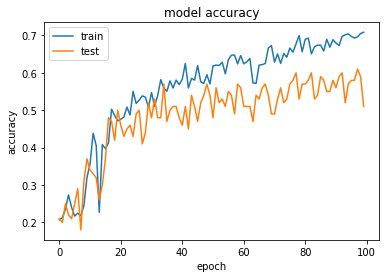

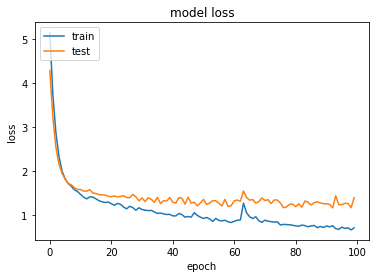

Training on fold 2/10


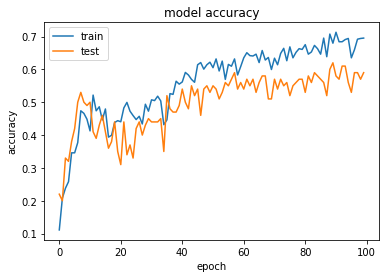

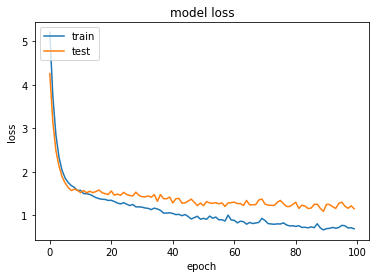

Training on fold 3/10


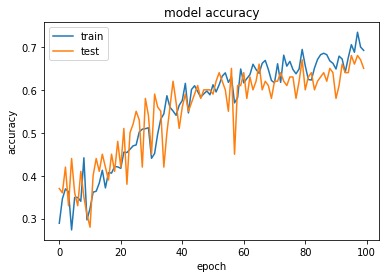

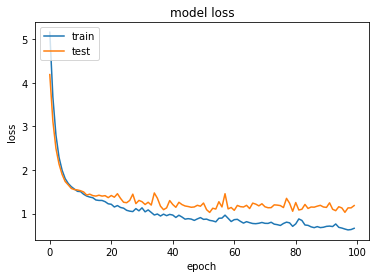

Training on fold 4/10


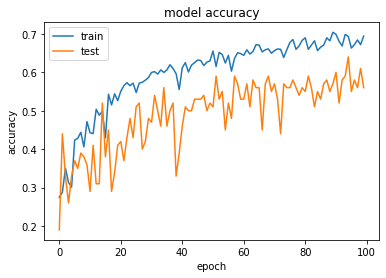

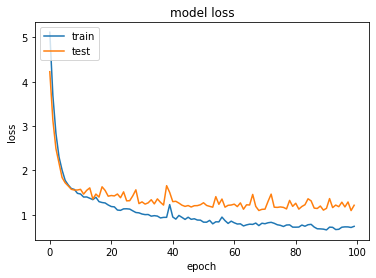

Training on fold 5/10


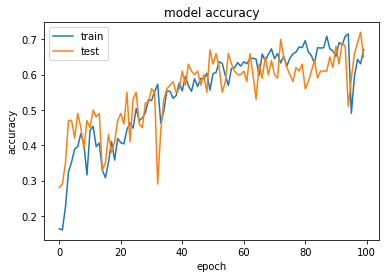

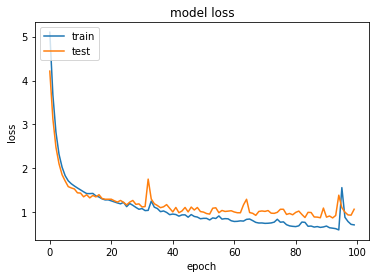

Training on fold 6/10


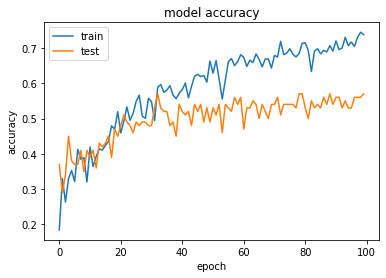

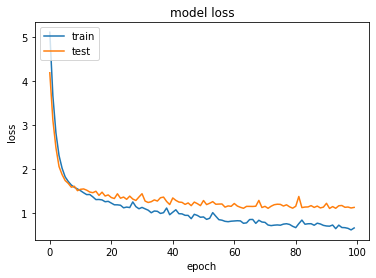

Training on fold 7/10


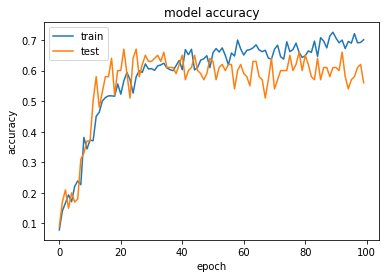

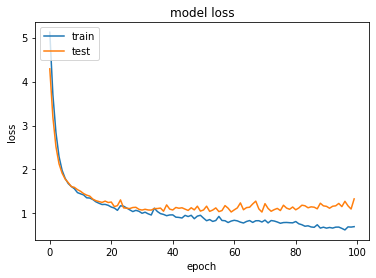

Training on fold 8/10


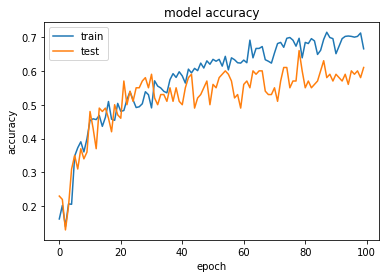

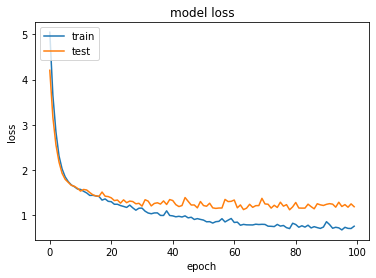

Training on fold 9/10


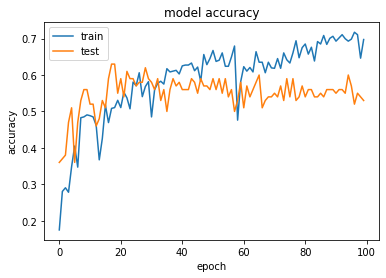

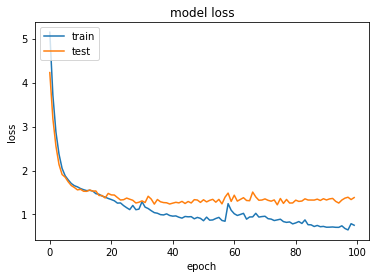

Training on fold 10/10


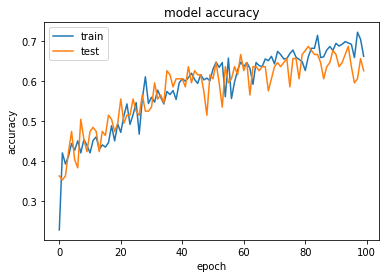

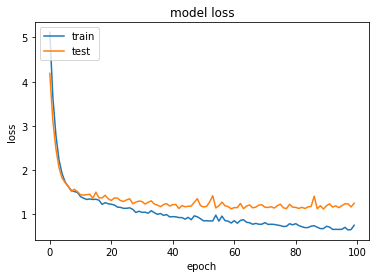

In [15]:
# 定義 K-fold 參數
num_folds = 10
skfold = StratifiedKFold(n_splits=num_folds, shuffle=True)
models = []

# 迭代每個 K-fold
fold = 1
for train_index, val_index in skfold.split(X_train, Y_train):
    print(f"Training on fold {fold}/{num_folds}")
    # 準備訓練集和驗證集的資料
    x_train, y_train, t_train, x_train_T = X_train[train_index], y_TrainOneHot[train_index], T_train[train_index], X_train_T[train_index]
    x_val, y_val, t_val, x_val_T = X_train[val_index], y_TrainOneHot[val_index], T_train[val_index], X_train_T[val_index]
    
    # define two sets of inputs
    inputA = Input(shape=(100, 74))
    inputC = Input(shape=(74, 100))
    inputB = Input(shape=(26,))
    # the first branch operates on the first input
    x = Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)), name='bilstm')(inputA)
    x = Dense(32, activation="relu", name='x2_dense')(x)
    x = Model(inputs=inputA, outputs=x)
    # the second branch opreates on the second input

    k = Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)), name='bilstm_2')(inputC)
    k = Dense(32, activation="relu", name='k1_dense')(k)
    k = Model(inputs=inputC, outputs=k)
    # the second branch opreates on the second input

    y = Dense(16, activation="relu", name='y1_dense')(inputB)
    y = Model(inputs=inputB, outputs=y)

    # combine the output of the two branches
    combined = concatenate([x.output, y.output, k.output])
    combined = Dropout(0.2)(combined)
    # apply a FC layer and then a regression prediction on the
    # combined outputs
    z = Dense(32, activation="relu", name='z1_dense', activity_regularizer=tf.keras.regularizers.l2(0.01))(combined)
    z = Dense(16, activation="relu", name='z3_dense')(z)
    z = Dense(5, activation="softmax")(z)
    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=[x.input, y.input, k.input], outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath='./fold_model/fold' + str(fold) + '_best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=0
    )
 
    # 訓練模型
    train_history = model.fit(
        x=[x_train, t_train, x_train_T],
        y=y_train,
        epochs=100,
        class_weight=class_weights,
        validation_data=([x_val, t_val, x_val_T], y_val),
        batch_size=32,
        verbose=0,
        callbacks = [checkpoint_callback]
    )
    best = load_model('./fold_model/fold' + str(fold) + '_best_model.h5')
    fold += 1
    models.append(best)

    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()
    # summarize history for loss 
    plt.plot(train_history.history['loss']) 
    plt.plot(train_history.history['val_loss']) 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import LSTM, Dense, Input, Masking, concatenate, Dropout, Bidirectional
# from tensorflow.keras.models import Model, load_model

# # define two sets of inputs
# inputA = Input(shape=(100, 74))
# inputC = Input(shape=(74, 100))
# inputB = Input(shape=(26,))
# # the first branch operates on the first input

# # x = Masking(mask_value=0)(inputA)
# x = Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)), name='bilstm')(inputA)
# # x = Dropout(0.2)(x)
# x = Dense(32, activation="relu", name='x2_dense')(x)
# x = Model(inputs=inputA, outputs=x)
# # the second branch opreates on the second input

# # x = Masking(mask_value=0)(inputA)
# k = Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=tf.keras.regularizers.L2(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)), name='bilstm_2')(inputC)
# # k = Dropout(0.2)(k)
# k = Dense(32, activation="relu", name='k1_dense')(k)
# # k = Dense(16, activation="relu", name='k2_dense')(k)
# k = Model(inputs=inputC, outputs=k)
# # the second branch opreates on the second input

# y = Dense(16, activation="relu", name='y1_dense')(inputB)
# # y = Dense(16, activation="relu", name='y2_dense')(y)
# # y = Dropout(0.2)(y)
# # y = Dense(16, activation="relu", name='y3_dense')(y)
# y = Model(inputs=inputB, outputs=y)

# # combine the output of the two branches
# combined = concatenate([x.output, y.output, k.output])
# combined = Dropout(0.2)(combined)
# # apply a FC layer and then a regression prediction on the
# # combined outputs
# z = Dense(32, activation="relu", name='z1_dense', activity_regularizer=tf.keras.regularizers.l2(0.01))(combined)
# z = Dense(16, activation="relu", name='z3_dense')(z)
# z = Dense(5, activation="softmax")(z)
# # our model will accept the inputs of the two branches and
# # then output a single value
# model = Model(inputs=[x.input, y.input, k.input], outputs=z)
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])


# # 創建 ModelCheckpoint 回調
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath='./fold_model/best1_model.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False,
#     mode='min',
#     verbose=0
# )

# model.summary()

# train_history = model.fit(x=[X_train, T_train, X_train_T], y=y_TrainOneHot, validation_data=([X_valid, T_valid, X_valid_T], y_ValidOneHot), epochs=100, class_weight=class_weights, batch_size=32, verbose=1, callbacks = [checkpoint_callback])  

In [ ]:
# from matplotlib import pyplot as plt
# print(train_history.history.keys())
# plt.plot(train_history.history['accuracy'])
# plt.plot(train_history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left') 
# plt.show()
# # summarize history for loss 
# plt.plot(train_history.history['loss']) 
# plt.plot(train_history.history['val_loss']) 
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left') 
# plt.show()

In [16]:
# from tensorflow.keras.models import Model, load_model
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

# model = load_model('./fold_model/best1_model.h5')
# frame_pred = model.predict([X_valid, T_valid, X_valid_T])
# # frame_pred = model2.predict(X_valid)
# # frame_pred = model1.predict(T_valid)
# Y_pred = frame_pred.argmax(axis=1)
# Y_true = y_ValidOneHot.argmax(axis=1)

# results_recall = recall_score(Y_true, Y_pred, average=None)
# print("Valid result in each class: ", results_recall)
# print("Valid UAR(Unweighted Average Recall) :", results_recall.mean())

# ConfusionMatrixDisplay(confusion_matrix(Y_true, Y_pred)).plot(cmap='Blues')